In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')
import important_functionalities as impf

2025-03-13 19:23:19.278173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2.4. Running a model experiment using 10% of augmented training data**

In [4]:
import os 
os.getcwd()

'/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/7_transfer_learning_fine_tuning'

In [5]:
# load data
data_dir='/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/test'

impf.walkthrough_directories(data_dir)

There are 2 directories and 0 images in /home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent
There are 10 directories and 0 images in /home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent/test
There are 0 directories and 250 images in /home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in /home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in /home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/6_transfer_learning_feature_extraction/10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in /

In [6]:
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=IMAGE_SHAPE,
                                                               label_mode='categorical',
                                                                batch_size=BATCH_SIZE
                                                               )
valid_data=tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                               image_size=IMAGE_SHAPE,
                                                                label_mode='categorical',
                                                                 batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


| Experiment | Data       | Preprocessing | Model          |
|------------|------------|---------------|----------------|
| Model 2     | Same as Model 0  | Same as Model 1       | Same as Model 0|

In [8]:
# Creating Model 2

### 1. Create data augmentation stage with horizontal flipping, rotations, zooms etc

### We can create a layer for our functional API models using Sequential API
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.experimental.preprocessing.Rescaling(1./255)# keep for models like ResNet50V2 but EfficientNet has rescaling built-in,
],name='data_augmentation')

In [12]:
input_shape=(224,224,3)
### 2. Create the base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False,#exclude o/p layer
                                                                  weights='imagenet',
                                                                 input_shape=input_shape) 

### 3. Freeze the layers in the base model
base_model.trainable=False # keeps  model in inference mode, this also ensures batchnorm statistics don't get updated

### 4. Create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')    
print(f"Shape of inputs: {inputs.shape}")
### 5. Adding data augmentation sequential layer model as a layer
x=data_augmentation(inputs,training=True)
print(f"Shape after data_augmentation: {x.shape}") 

### 6. Pass the inputs to the base_model
x = base_model(x)
print(f"Shape after base_model: {x.shape}")

### 7. max pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_max_pooling_layer')(x)
print(f"After GlobalmaxPooling2D(): {x.shape}")

### 8. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

### 9. Combine the inputs with the outputs into a model
model_2=tf.keras.Model(inputs,outputs)


### 10. Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### 11. Viewing model summary
model_2.summary()

Shape of inputs: (None, 224, 224, 3)
Shape after data_augmentation: (None, None, None, 3)
Shape after base_model: (None, None, None, 1280)
After GlobalmaxPooling2D(): (None, 1280)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_layer        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

**2.4.1. Creating a model checkpoint callback**

* It intermediately saves our model, the full model or just the weights during training.
* It is useful so that we can comeback and start where we left off.
* Save best only will only save weights for the best val_loss

In [15]:
### 12. Creating a model checkpoint callback
##### set checkpoint path
checkpoint_path = "model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5"

#### create model checkpoint which saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)


### 11. Fit the model and save its history
initial_epochs=5
history_10_percent_model_2=model_2.fit(train_data,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=int(0.25*len(valid_data)),
                               callbacks=[impf.create_tensorboard_callback(dir_name="transfer_learning",     experiment_name="10_percent_feature_extraction_data_aug"),checkpoint_callback])

Saving TensorBoard log files to : transfer_learning/10_percent_feature_extraction_data_aug/20250313-194915
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.1872 - loss: 2.2300
Epoch 1: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1914 - loss: 2.2231 - val_accuracy: 0.6316 - val_loss: 1.5756
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.5524 - loss: 1.6077
Epoch 2: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5540 - loss: 1.6034 - val_accuracy: 0.7303 - val_loss: 1.1340
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.7032 - loss: 1.2013
Epoch 3: saving model to model_checkpoints/10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7033 - loss: 1.2002 - val_accuracy: 0.7747 - val_

In [18]:
results_2_percent_data_aug=model_2.evaluate(valid_data)
results_2_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 709ms/step - accuracy: 0.8146 - loss: 0.6891


[0.7031430602073669, 0.8123999834060669]

<Figure size 640x480 with 0 Axes>

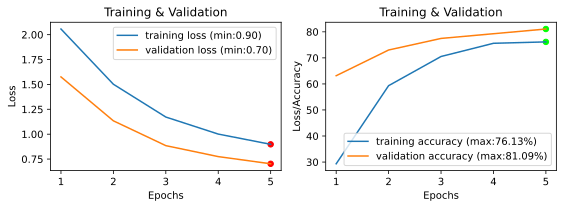

In [17]:
impf.plot_loss_curves(history_10_percent_model_2)

**2.4.2. Loading in model/model weights using saved checkpoints**

* It returns a model to specific checkpoint
* The difference in value is very neglible and is due to the way computers store in numbers (precision)

In [ ]:
# load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [19]:
# evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(valid_data)  

79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 665ms/step - accuracy: 0.8133 - loss: 0.6911


In [20]:
# check to see if the loaded model results are very close to previous results of non-loaded model
np.isclose(results_2_percent_data_aug, loaded_weights_model_results)

array([ True,  True])

In [22]:
# check the difference between two results 
print(np.array(loaded_weights_model_results)-np.array(results_2_percent_data_aug))

[-1.1920929e-07  0.0000000e+00]


***-- CONTD IN NEXT NOTEBOOK --***